In [1]:
import numpy as np
import pandas as pd
import flopy
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
# %config InlineBackend.figure_format = 'svg'
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
config = {
    'font.family':'Times New Roman',
    'font.size': 15,
    'font.serif': ['SimSun'],
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset':'stix',
    'savefig.dpi':300,
}
plt.rcParams.update(config)

虚构数据：
5000m长宽，100*100分辨率

z顶部高程随机-10到+10之间，含水层厚度随机10到100之间，以此计算z底部高程

网格渗流系数随机生成算法：
1. 随机选2到5个起点，随机渗流系数1到10之间
2. 对其余所有点：测量曼哈顿距离，挑选最近的起点的渗流系数

随机1到5口水井，每个水井随机-600到+600抽放水速率

左、右、上边界随机定水头数值1到4之间


In [2]:
class RandomGroundEnv:
    # ground info
    height = 5000.0  # meter
    width = 5000.0  # meter
    num_row = 100
    num_col = 100
    delta_row = height / num_row
    delta_col = width / num_col

    z_top = np.random.random() * 20 - 10  # meter
    z_delta = np.random.random() * 90 + 10  # meter
    z_bottom = z_top - z_delta
    num_layer = 1
    bottom_arr = np.linspace(z_top, z_bottom, num_layer + 1)

    # 边界水头
    boundary = np.ones((num_layer, num_row, num_col), dtype=np.int32)
    boundary[:, :, 0] = -1
    boundary[:, :, -1] = -1
    boundary[:, 0, 1:-1] = -1
    starting_head = np.ones((num_layer, num_row, num_col), dtype=np.float32)
    starting_head[:, :, 0] = np.random.random() * 3 + 1
    starting_head[:, :, -1] = np.random.random() * 3 + 1
    starting_head[:, 0, 1:-1] = np.random.random() * 3 + 1

    # 含水层
    seed_num = np.random.randint(2, 6)
    seed_pos = np.random.randint(100, size=(seed_num, 2))
    seed_coeff = np.random.random(size=(seed_num)) * 9 + 1
    layer_property = np.ones((num_layer, num_row, num_col), dtype=np.float32)
    for r in range(num_row):
        for c in range(num_col):
            _pos = np.array([r, c])
            _distances = np.sum(np.abs(_pos - seed_pos), axis=1)
            _nearest = np.argmin(_distances)
            layer_property[:, r, c] = seed_coeff[_nearest]

    # well
    well_num = np.random.randint(1, 6)
    well_stress_data = {
        0: [
            [
                0, 
                np.random.randint(100), 
                np.random.randint(100), 
                np.random.random() * 1200 - 600
            ] for _ in range(well_num)
        ]
    }

# 

In [3]:
param = RandomGroundEnv()
model_path = "mock_data"
model_name = "mdata_0"
mf_obj = flopy.modflow.Modflow(
    model_name,
    model_ws=model_path,
)
discretization = flopy.modflow.ModflowDis(
    mf_obj,
    param.num_layer, 
    param.num_row, 
    param.num_col,
    delr=param.delta_row,
    delc=param.delta_col,
    top=param.z_top,
    botm=param.bottom_arr[1:],
)
basic_info = flopy.modflow.ModflowBas(
    mf_obj,
    ibound=param.boundary,
    strt=param.starting_head,
)
layer_property_flow = flopy.modflow.ModflowLpf(
    mf_obj,
    hk=param.layer_property,
)
well_obj = flopy.modflow.ModflowWel(
    mf_obj,
    stress_period_data=param.well_stress_data
)

In [4]:
# output config
stress_period_oc = {(0, 0): ["print head", "print budget", "save head", "save budget"]}
output_config = flopy.modflow.ModflowOc(
    mf_obj,
    stress_period_data=stress_period_oc,
    compact=True,
)
pcg = flopy.modflow.ModflowPcg(mf_obj)

In [5]:
mf_obj.write_input()
succ_flag, buff = mf_obj.run_model()
if not succ_flag:
    raise RuntimeError("ERROR")

FloPy is using the following executable to run the model: ..\..\..\..\..\modflow\MF2005.1_12\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mdata_0.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/07/11 13:29:06

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/07/11 13:29:06
 Elapsed run time:  0.061 Seconds

  Normal termination of simulation


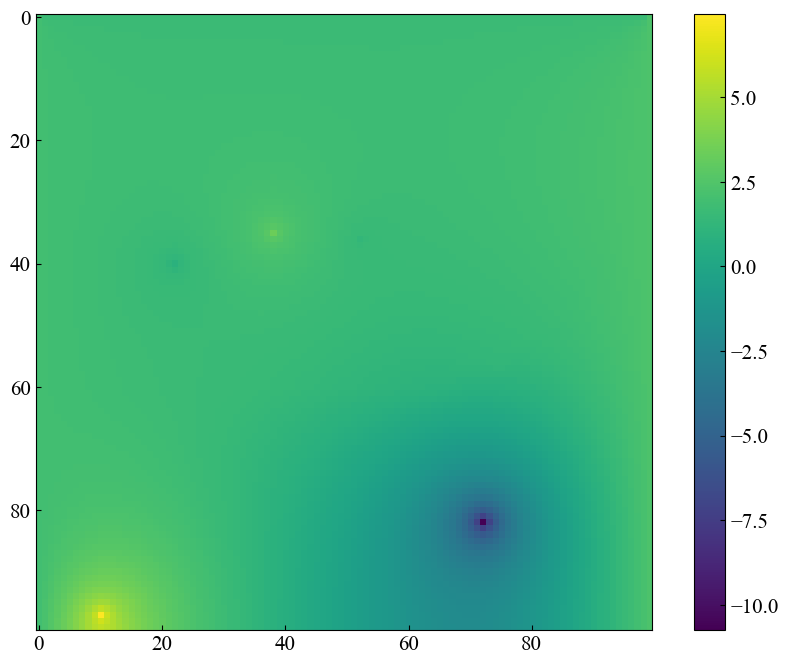

In [6]:
# 提取水头数据
hds = bf.HeadFile(f'./{model_path}/{model_name}.hds')
head = hds.get_data(totim=1.0)
df = pd.DataFrame(head[0])
plt.figure(figsize=(11,8))
plt.imshow(df)
plt.colorbar()